In [1]:
%pip install lime
%pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

# automatically refresh imported modules
%reload_ext autoreload
%autoreload 2

## for data
import json
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection
## for explainer
from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
from sklearn import metrics

import tensorflow as tf

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
# for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

In [5]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [ ]:
old_path = "/Users/victor/Documents/Confidential Dataset/ML_NOAC_NOVA_Extraction_Cleaned_DF3_Full.csv"
path = '/content/drive/MyDrive/Documents importants/Academic/MIT/Fall/15_572_Analytics_lab/Google Colab - ALab/Data/ML_NOAC_NOVA_Extraction_Cleaned_DF3_Full.csv'

df = pd.read_csv(path)
df.head()

In [ ]:
var_used = "EmailObject"
df = df[['Type', var_used]]
df.head()

In [8]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [9]:
lst_stopwords = nltk.corpus.stopwords.words("english")

df["text_clean"] = df[var_used].progress_apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

100%|██████████| 251234/251234 [00:07<00:00, 32237.79it/s]


In [10]:
## split dataset
df_train, df_test = model_selection.train_test_split(df, test_size=0.3)

## get target
y_train = df_train["Type"].values
y_test = df_test["Type"].values


# BAG OF WORDS

In [11]:
## Count (classic BoW)
vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))

## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [12]:
corpus = df_train["text_clean"]

vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [13]:
y = df_train["Type"]

X_names = vectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()

for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))

    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])

    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
    
X_names = dtf_features["feature"].unique().tolist()


In [14]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
   print("  . top features:", ",".join(

dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
   print(" ")


# 0:
  . selected features: 3971
  . top features: 20220301,20220302,20220303,20220304,20220307,20220309,20220310,20220315,ach,alert
 
# 1:
  . selected features: 3971
  . top features: 20220301,20220302,20220303,20220304,20220307,20220309,20220310,20220315,ach,alert
 


In [15]:
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)

vectorizer.fit(corpus)

X_train = vectorizer.transform(corpus)

dic_vocabulary = vectorizer.vocabulary_

In [16]:
classifier = naive_bayes.MultinomialNB()

## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = df_test["text_clean"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Accuracy: 0.75
Auc: 0.8
Detail:
              precision    recall  f1-score   support

           0       0.78      0.88      0.83     51321
           1       0.65      0.46      0.54     24050

    accuracy                           0.75     75371
   macro avg       0.71      0.67      0.68     75371
weighted avg       0.74      0.75      0.73     75371



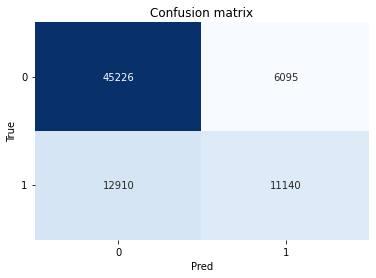

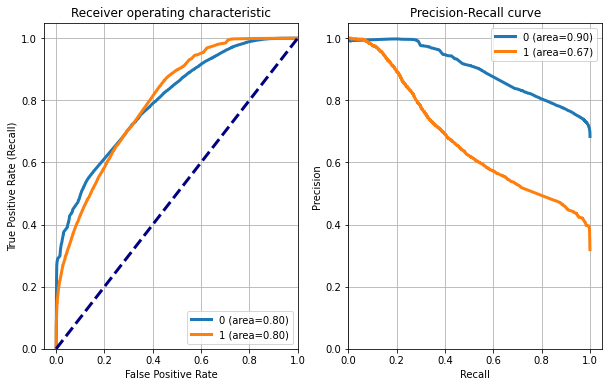

In [17]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test_array, predicted_prob, 
                            multi_class="ovr")
                            
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [18]:
## select observation
i = 3
txt_instance = df_test[var_used].iloc[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
## show explanation
explainer = lime_text.LimeTextExplainer(class_names=
             np.unique(y_train))
explained = explainer.explain_instance(txt_instance, 
             model.predict_proba, num_features=3)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

True: 0 --> Pred: 0 | Prob: 0.51


# Word Embedding

In [19]:
corpus = df_train["text_clean"]

## create list of lists of unigrams
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

In [20]:
## fit w2v
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300,   
            window=8, min_count=1, sg=1)

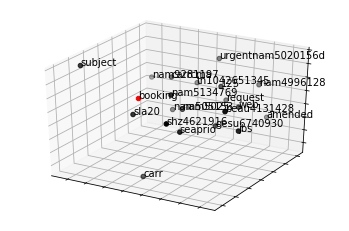

In [21]:
word = 'booking'
fig = plt.figure()

## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 nlp.wv.most_similar(word, topn=20)]
X = nlp[tot_words]
## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)
## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1
## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

In [22]:
# nlp.wv.vocab

In [23]:
## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode('utf-8'), min_count=5, threshold=10)

bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)

trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode('utf-8'), min_count=5, threshold=10)

trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [24]:
# lst_corpus

In [25]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')

tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index

## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")

In [26]:
i = 0

## list of text: ["I like this", ...]
len_txt = len(df_train["text_clean"].iloc[i].split())
print("from: ", df_train["text_clean"].iloc[i], "| len:", len_txt)

## sequence of token ids: [[1, 2, 3], ...]
len_tokens = len(X_train[i])
print("to: ", X_train[i], "| len:", len(X_train[i]))

## vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", df_train["text_clean"].iloc[i].split()[0], 
      " -- idx in vocabulary -->", 
      dic_vocabulary[df_train["text_clean"].iloc[i].split()[0]])

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")

from:  chs new eir whlu2859275 | len: 4
to:  [ 457   62  710 9770    0    0    0    0    0    0    0    0    0    0
    0] | len: 15
check:  chs  -- idx in vocabulary --> 457
vocabulary:  {'NaN': 1, 'booking': 2, 'request': 3, 'web': 4, 'carrcma': 5} ... (padding element, 0)


#### Don't forget to apply the same changes on the test dataset. We do it here

In [27]:
corpus = df_test["text_clean"]

## create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=15,
             padding="post", truncating="post")

In [28]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))

for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [29]:
word = "claim"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

dic[word]: 575 |idx
embeddings[idx]: (300,) |vector


In [30]:
# ## Build the neural network
# y_train = y_train.reshape((-1,1))
# y_test = y_train.reshape((-1,1))

In [31]:
metrics_network = [
    tf.keras.metrics.AUC(name='roc-auc'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name="recall")
]

## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="sigmoid")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(15,))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=15, trainable=False)(x_in)
## apply attention
x = attention_layer(x, neurons=15)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(1, activation='sigmoid')(x)
## compile
model = models.Model(x_in, y_out)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer='adam', 
              metrics=metrics_network)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 15, 300)      14298600    ['input_1[0][0]']                
                                                                                                  
 permute (Permute)              (None, 300, 15)      0           ['embedding[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 300, 15)      240         ['permute[0][0]']                
                                                                                              

In [32]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])

## train
training = model.fit(x=X_train, y=y_train, batch_size=256, epochs=100, shuffle=True, validation_split=0.3)

Epoch 1/100
481/481 [==============================] - 18s 21ms/step - loss: 0.5279 - roc-auc: 0.7237 - accuracy: 0.7099 - precision: 0.7047 - recall: 0.1481 - val_loss: 0.4982 - val_roc-auc: 0.7599 - val_accuracy: 0.7195 - val_precision: 0.7572 - val_recall: 0.1725
Epoch 2/100
481/481 [==============================] - 10s 20ms/step - loss: 0.4996 - roc-auc: 0.7565 - accuracy: 0.7207 - precision: 0.7542 - recall: 0.1778 - val_loss: 0.4920 - val_roc-auc: 0.7699 - val_accuracy: 0.7236 - val_precision: 0.7579 - val_recall: 0.1910
Epoch 3/100
481/481 [==============================] - 8s 17ms/step - loss: 0.4948 - roc-auc: 0.7647 - accuracy: 0.7229 - precision: 0.7199 - recall: 0.2075 - val_loss: 0.4900 - val_roc-auc: 0.7749 - val_accuracy: 0.7247 - val_precision: 0.7552 - val_recall: 0.1977
Epoch 4/100
481/481 [==============================] - 8s 18ms/step - loss: 0.4911 - roc-auc: 0.7713 - accuracy: 0.7245 - precision: 0.7012 - recall: 0.2298 - val_loss: 0.4872 - val_roc-auc: 0.7794 - 

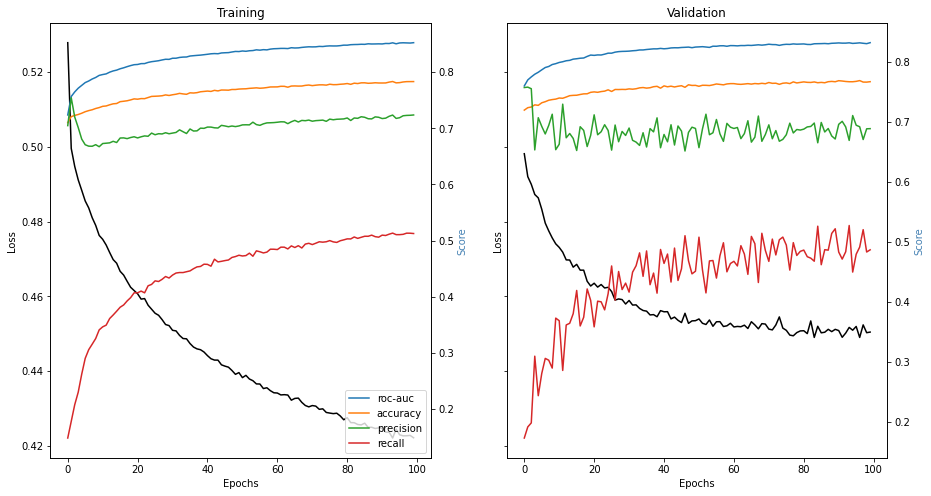

In [33]:
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,8))
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

In [34]:
## test
predicted_prob = model.predict(X_test)
predicted_prob = np.column_stack((1-predicted_prob.reshape(-1), predicted_prob.reshape(-1)))

2356/2356 [==============================] - 14s 5ms/step


In [35]:
predicted = np.argmax(predicted_prob, axis=1)

In [36]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test_array, predicted_prob, 
                            multi_class="ovr")
                            
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
          
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

AttributeError: ignored